# 2021-01-13 • Multiple ROC's

Here we repeat the simulation multiple times (each time varying one parameter), and for each repetition calculate an ROC curve (and associated area under that curve): how well could we classify all (spike_train, VI_signal)-pairs as connected or unconnected, for a range of p-value thresholds?

## Setup

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [169]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Fri 15 Jan** 2021, at 00:24 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/4a95f342a6f06b7b6fe4f5fcdf76a7bbcb372fb1
) (Thu 14 Jan 2021, 23:47).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/N_to_1_experiment.py
 M codebase/voltage_to_wiring_sim/conntest/permutation_test.py
 M codebase/voltage_to_wiring_sim/support/util.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

In [3]:
from voltage_to_wiring_sim.N_to_1_experiment import N_to_1_SimParams, simulate, sim_and_eval, plot_slice

In [4]:
from voltage_to_wiring_sim.sim.neuron_params import cortical_RS

## Base parameters

In [5]:
sim_params = N_to_1_SimParams(
    sim_duration = 5 * minute,
    timestep = 0.1 * ms,
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = cortical_RS,
    imaging_spike_SNR = 4,
);

In [6]:
sim_data = simulate(sim_params);

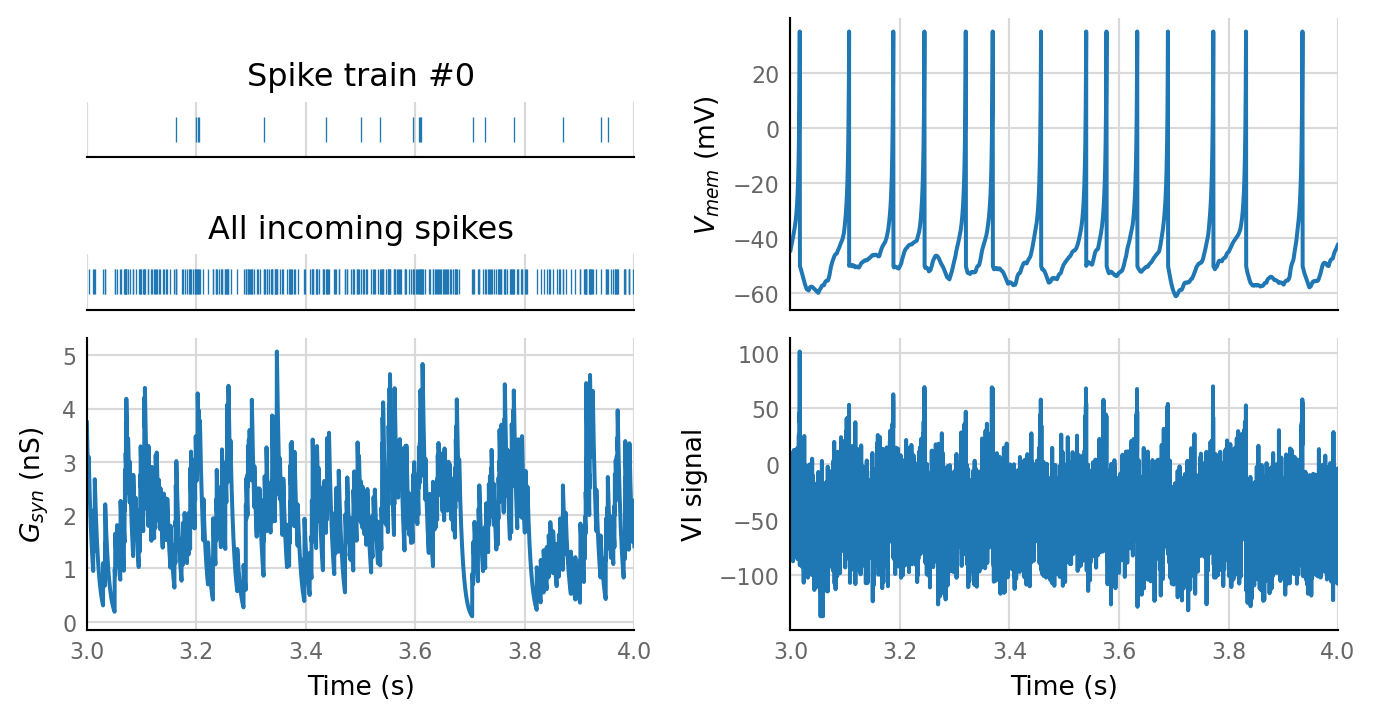

In [113]:
plot_slice(sim_data, t_start=3 * second, duration=1 * second);

In [8]:
test_data, test_summaries = v.N_to_1_experiment.test_connections(sim_data);

Testing connections: 100%|██████████| 30/30 [00:06<00:00,  4.68it/s]


In [11]:
td = test_data[0];

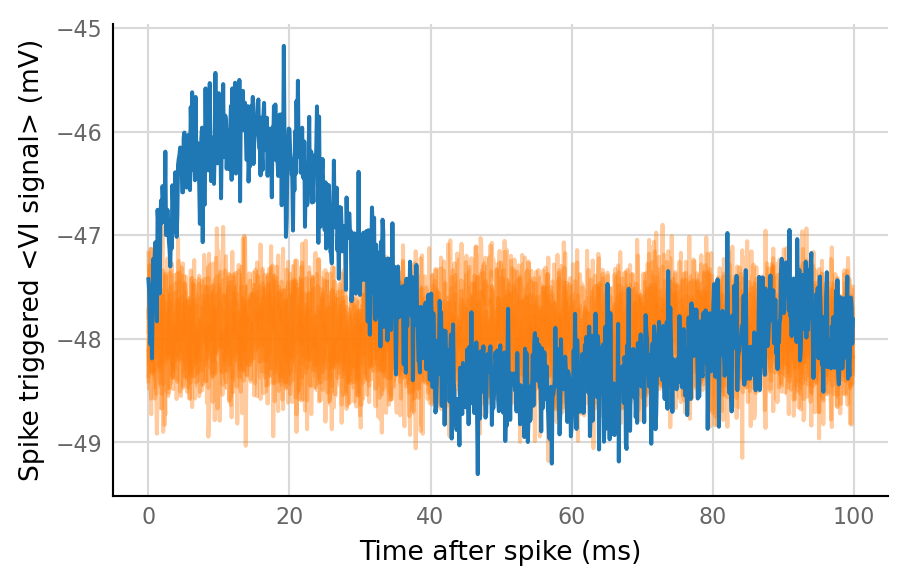

In [65]:
v.conntest.permutation_test.plot_STAs(td);

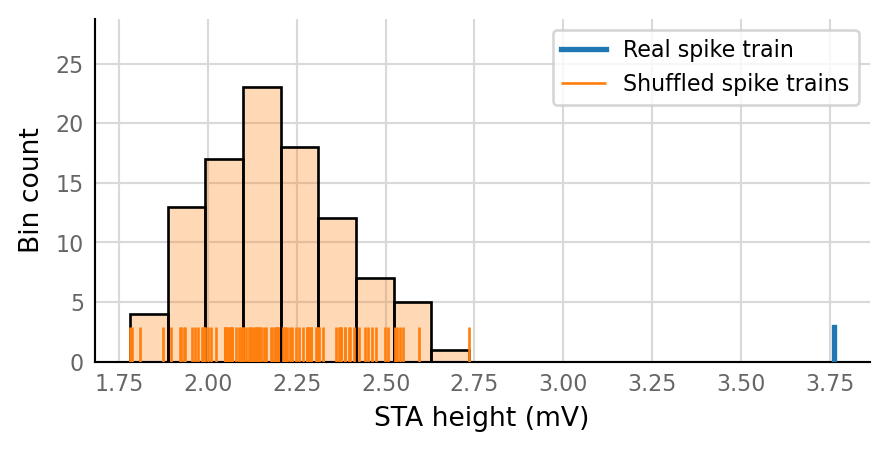

In [121]:
v.conntest.permutation_test.plot_STA_heights(td);

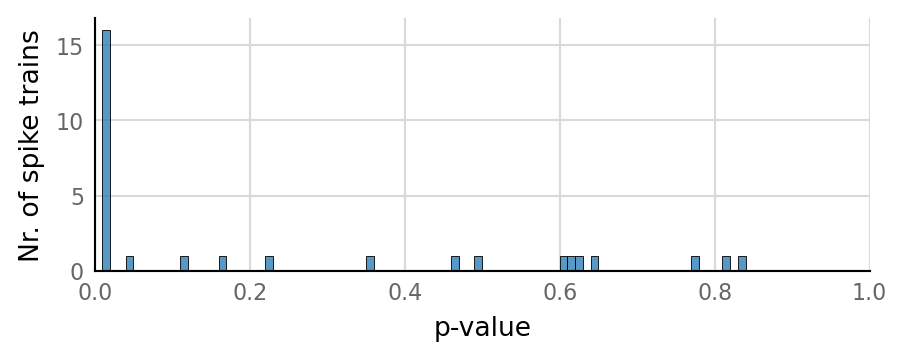

In [166]:
v.N_to_1_experiment.plot_p_values(test_summaries)

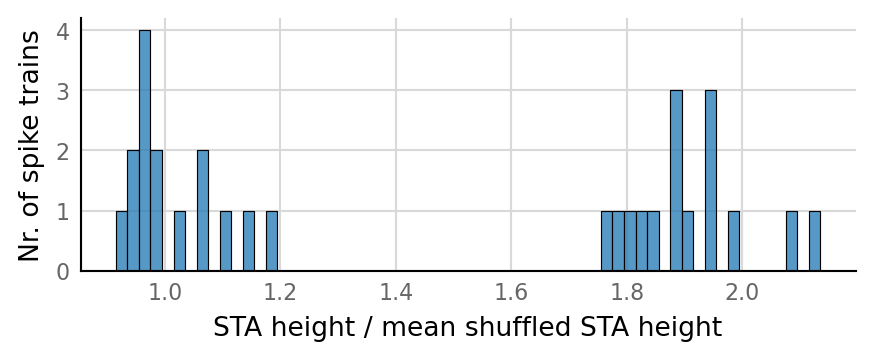

In [167]:
v.N_to_1_experiment.plot_relative_STA_heights(test_summaries)

In [115]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Thu 14 Jan** 2021, at 23:44 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/42543b0f525ec7169850c69252d824659facbc66
) (Thu 14 Jan 2021, 23:40).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/N_to_1_experiment.py
 M codebase/voltage_to_wiring_sim/__init__.py
 M notebooks/2021-01-13__multiple_ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.6 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.5
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
py-cpuinfo           7.0.0
nptyping             1.4.0
tqdm                 4.56.0
